In [192]:
from functions import transform_raw_data, clean_df, impute_fit_df, impute_transform_df

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#from xgboost import XGBClassifier

import mlflow
import numpy as np
import pandas as pd
from collections import Counter


In [2]:
# creating dictionary of categorical column names : corresponding one-hot encoded columns names
# this is used to make sure every X dataset in the CV has the same columns
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
categorical_columns = [col for col in df.select_dtypes(include='object').columns if col not in ['time','engine_capacity_cc','casualty_severity']] + ['speed_limit']
df = clean_df(df)
categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler = impute_fit_df(df)
df = impute_transform_df(df, categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler, df.columns)

encoded_cols_dict = {}

for col in categorical_columns:
    encoded_cols = [encoded_col for encoded_col in df.columns if col in encoded_col]
    if len(encoded_cols) > 0:
        encoded_cols_dict[col] = encoded_cols

In [3]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
df = clean_df(df)

In [4]:
# custom Transformer class for applying preprocessing in pipeline
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_encoded_cols=None):
        self.categorical_freqs = None
        self.continuous_medians_grouped = None
        self.continuous_medians = None
        self.vars_to_groupby = None
        self.scaler = None
        self.features = None
        self.one_hot_encoded_cols = one_hot_encoded_cols

    # fit is only called on the train data
    def fit(self, X, y=None):
        # calculate impute values
        self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped, self.continuous_medians, self.scaler = impute_fit_df(X)
        return self

    # transform is called on the both the train and test data
    def transform(self, X, y=None):
        # apply the preprocessing function to the data
        df = impute_transform_df(X, self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped,
                                 self.continuous_medians, self.scaler, X.columns,
                                 encoded_cols_dict=encoded_cols_dict, one_hot_encoded_cols=self.one_hot_encoded_cols)
        self.features = df.columns
        return df

In [5]:
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','junction_detail','towing_and_articulation','vehicle_manoeuvre',
            'casualty_imd_decile','pedestrian_crossing_physical_facilities','driver_imd_decile',
            'day_of_week','time_period','season',
            'first_road_class','road_type','speed_limit','junction_control','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','propulsion_code']
target = 'casualty_severity'

In [6]:
# baseline accuracy -> dummy classifier predicting the most frequent class
pipeline = Pipeline([
    ('custom_preprocessor', CustomPreprocessor()),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)
pipeline.fit(X_train, y_train)
y_pred_dummy = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_dummy)
precision = precision_score(y_test, y_pred_dummy, average='macro')
recall = recall_score(y_test, y_pred_dummy, average='macro')
f1 = f1_score(y_test, y_pred_dummy, average='macro')

print(accuracy, precision, recall, f1)

0.7815126050420168 0.2605042016806723 0.3333333333333333 0.29245283018867924


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# # create a new MLflow experiment
# mlflow.set_experiment("cycle collisions")
# with mlflow.start_run():
#     pipeline = Pipeline([
#         ('custom_preprocessor', CustomPreprocessor()),
#         ('classifier', SVC())
#     ])
#     cv = StratifiedKFold(n_splits=5)
#     scores = cross_val_score(pipeline, X=df[features], y=df[target], cv=cv, scoring=accuracy_score)

#     mlflow.log_params(pipeline.get_params())
#     mlflow.log_metric("accuracy", accuracy)

### 1. initial experimentation
#### 1.1. testing different features

In [8]:
def run_experiment(features):
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', RandomForestClassifier(class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=5)
    scoring = {
        'acc': make_scorer(accuracy_score), 
        'rec': 'recall_macro', 
        'f1': 'f1_macro'
    }
    scores = cross_validate(pipeline, X=df[features], y=df[target], cv=cv, scoring=scoring, return_train_score=True)
    return scores

In [9]:
# all features
features = ['engine_capacity_cc',
            'vehicle_type','junction_detail','towing_and_articulation','vehicle_manoeuvre',
            'pedestrian_crossing_physical_facilities',
            #'day_of_week','time_period','season',
            'first_road_class','road_type','speed_limit','junction_control','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','propulsion_code']
run_experiment(features)

{'fit_time': array([1.56996536, 1.52224374, 1.42052174, 1.44374108, 1.41251683]),
 'score_time': array([0.09353304, 0.091784  , 0.09565806, 0.09146833, 0.09922385]),
 'test_acc': array([0.77540107, 0.7675841 , 0.75764526, 0.76376147, 0.73929664]),
 'train_acc': array([0.90921254, 0.91840245, 0.91706478, 0.91840245, 0.90368813]),
 'test_rec': array([0.34385788, 0.34889101, 0.34044715, 0.33699187, 0.34060021]),
 'train_rec': array([0.7656144 , 0.86810237, 0.86250702, 0.83802663, 0.81356057]),
 'test_f1': array([0.32362456, 0.33745979, 0.32595264, 0.31612526, 0.33239439]),
 'train_f1': array([0.81592967, 0.89841591, 0.89520227, 0.86648333, 0.84716389])}

In [10]:
# selecting subset of features
features = ['towing_and_articulation','pedestrian_crossing_physical_facilities',
            'road_type','speed_limit',
            'first_road_class','second_road_class']
run_experiment(features)

{'fit_time': array([0.54657888, 0.53218675, 0.56710386, 0.55690432, 0.51949167]),
 'score_time': array([0.05927968, 0.05083418, 0.0627563 , 0.05877805, 0.05453706]),
 'test_acc': array([0.57066463, 0.58333333, 0.52752294, 0.53899083, 0.41666667]),
 'train_acc': array([0.62308869, 0.6388305 , 0.55474871, 0.61112173, 0.58895471]),
 'test_rec': array([0.31525388, 0.34456615, 0.31264808, 0.43090786, 0.38029135]),
 'train_rec': array([0.66505105, 0.68777401, 0.68591072, 0.69847864, 0.68894845]),
 'test_f1': array([0.32338416, 0.33767866, 0.31512124, 0.3263045 , 0.27677028]),
 'train_f1': array([0.40226151, 0.42335231, 0.37582961, 0.39887592, 0.38600563])}

In [11]:
features = ['first_road_class','speed_limit','second_road_class',
            'light_conditions','vehicle_type']
run_experiment(features)

{'fit_time': array([0.65494442, 0.56204867, 0.55223417, 0.55620861, 0.53623676]),
 'score_time': array([0.06107402, 0.04671574, 0.05372119, 0.04907823, 0.05201411]),
 'test_acc': array([0.60886173, 0.61085627, 0.62844037, 0.52599388, 0.45489297]),
 'train_acc': array([0.66972477, 0.68029811, 0.69386585, 0.63080451, 0.64494554]),
 'test_rec': array([0.3185985 , 0.3356086 , 0.330482  , 0.30940186, 0.29869259]),
 'train_rec': array([0.74210019, 0.74786743, 0.74343937, 0.74504999, 0.73543875]),
 'test_f1': array([0.32315839, 0.33263563, 0.33234496, 0.30428831, 0.28118558]),
 'train_f1': array([0.43936081, 0.48105053, 0.44424066, 0.43242711, 0.43456533])}

In [12]:
features = ['first_road_class','speed_limit','second_road_class',
            'light_conditions','vehicle_type',
            'road_surface_conditions','junction_detail']
run_experiment(features)

{'fit_time': array([0.81480217, 0.82256866, 0.88712478, 0.78518558, 0.8057704 ]),
 'score_time': array([0.06944132, 0.0604558 , 0.07017374, 0.07094932, 0.06343222]),
 'test_acc': array([0.6065699 , 0.62308869, 0.58792049, 0.60703364, 0.50840979]),
 'train_acc': array([0.70584862, 0.74183069, 0.7070514 , 0.70036308, 0.70552264]),
 'test_rec': array([0.32106704, 0.32445216, 0.34093496, 0.33349013, 0.33180767]),
 'train_rec': array([0.80019184, 0.80382865, 0.80184881, 0.79533903, 0.79271611]),
 'test_f1': array([0.32158834, 0.32394086, 0.33271543, 0.33077456, 0.30829435]),
 'train_f1': array([0.53256077, 0.63803738, 0.52460856, 0.52591369, 0.52676522])}

#### 1.4 Applying SMOTE

In [89]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
categorical_columns = [col for col in df.select_dtypes(include='object').columns if col not in ['time','engine_capacity_cc','casualty_severity']] + ['speed_limit']
df = clean_df(df)
categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler = impute_fit_df(df)
df = impute_transform_df(df, categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler, df.columns)

# summarize class distribution
counter = Counter(df[target])
print(counter)

over = SMOTE(sampling_strategy={'Slight': 5124, 'Serious': 1403, 'Fatal': 1000})
under = RandomUnderSampler(sampling_strategy={'Slight': 2000, 'Serious': 1403, 'Fatal': 1000})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(df.drop(columns=[target, 'time']), df[target])
counter = Counter(y)
print(counter)

Counter({'Slight': 5124, 'Serious': 1403, 'Fatal': 14})
Counter({'Slight': 2000, 'Fatal': 1000, 'Serious': 1000})


In [90]:
def run_experiment(features, one_hot_encoded_cols=None):
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy={'Slight': 5124, 'Serious': 1403, 'Fatal': 1000})),
        ('under', RandomUnderSampler(sampling_strategy={'Slight': 2000, 'Serious': 1403, 'Fatal': 1000})),
        ('classifier', RandomForestClassifier())
    ])
    cv = StratifiedKFold(n_splits=5)
    scoring = {
        'acc': make_scorer(accuracy_score), 
        'rec': 'recall_macro', 
        'f1': 'f1_macro'
    }
    scores = cross_validate(pipeline, X=df[features], y=df[target], cv=cv, scoring=scoring, return_train_score=True, verbose=10)
    return scores

In [92]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
df = clean_df(df)
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'propulsion_code','vehicle_type']
run_experiment(features)

{'fit_time': array([10.6518991 , 10.67143345,  9.97269583,  9.62056494,  9.55506301]),
 'score_time': array([0.60267711, 0.35906339, 0.35869598, 0.35229087, 0.34649801]),
 'test_acc': array([0.61497326, 0.60779817, 0.62844037, 0.62844037, 0.62232416]),
 'train_acc': array([0.81326453, 0.80909612, 0.81960634, 0.82170839, 0.8173132 ]),
 'test_rec': array([0.33842085, 0.34722333, 0.34865273, 0.34346109, 0.35621015]),
 'train_rec': array([0.82838843, 0.85869903, 0.86133261, 0.83480697, 0.82752272]),
 'test_f1': array([0.3347085 , 0.33962595, 0.34410214, 0.3400867 , 0.34899596]),
 'train_f1': array([0.7130054 , 0.73900334, 0.70797933, 0.75911339, 0.7217271 ])}

#### 1.2. Looking at feature importances

In [24]:
pipeline = Pipeline([
    ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
    ('over', SMOTE(sampling_strategy={'Slight': 5124, 'Serious': 1403, 'Fatal': 1000})),
    ('under', RandomUnderSampler(sampling_strategy={'Slight': 2000, 'Serious': 1403, 'Fatal': 1000})),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

feature_importances = [i for i in enumerate(pipeline['classifier'].feature_importances_)]
arr = np.array(feature_importances)
arr = arr[arr[:, 1].argsort()[::-1]]
feature_importances = [(pipeline['custom_preprocessor'].features[int(i[0])], i[1]) for i in arr]
feature_importances

[('propulsion_code_Heavy oil', 0.05360552553510866),
 ('age_of_casualty', 0.04433305281555815),
 ('engine_capacity_cc', 0.04042357892079915),
 ('road_type_Dual carriageway', 0.033025764564132705),
 ('light_conditions_Darkness - lights lit', 0.030859252596146063),
 ('age_of_driver', 0.030699899946616448),
 ('time_period_0:00 - 4:00', 0.030417652271352114),
 ('second_road_class_Not at junction or within 20 metres', 0.0228531661269339),
 ('vehicle_type_Bus or coach (17 or more pass seats)', 0.02227517345720511),
 ('vehicle_manoeuvre_Going ahead other', 0.02174720311944432),
 ('first_road_class_A', 0.017613911649249046),
 ('speed_limit_30', 0.017215427662903234),
 ('junction_detail_Not at junction or within 20 metres', 0.01643443336132435),
 ('driver_imd_decile_More deprived 30-40%', 0.015378645731364039),
 ('speed_limit_20', 0.014676492713764708),
 ('season_spring', 0.014301965301952243),
 ('casualty_imd_decile_More deprived 10-20%', 0.013237576914540338),
 ('pedestrian_crossing_physical_

In [27]:
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'road_type','light_conditions','vehicle_type']
run_experiment(features)

{'fit_time': array([2.802742  , 2.62744784, 2.51885009, 2.66364765, 2.52011228]),
 'score_time': array([0.07708216, 0.07598734, 0.07301235, 0.068542  , 0.08496332]),
 'test_acc': array([0.66921314, 0.68042813, 0.66972477, 0.67737003, 0.64525994]),
 'train_acc': array([0.96081804, 0.96350086, 0.96311867, 0.96273648, 0.95738582]),
 'test_rec': array([0.34342852, 0.35228655, 0.34631243, 0.33918118, 0.33585062]),
 'train_rec': array([0.90023022, 0.9338999 , 0.90188036, 0.96280764, 0.92726418]),
 'test_f1': array([0.3429738 , 0.35202759, 0.34580708, 0.33922306, 0.33513651]),
 'train_f1': array([0.91384549, 0.94926   , 0.91617269, 0.94864202, 0.94203175])}

#### 1.5 Selecting features from EDA correlation plots

In [20]:
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','junction_detail','towing_and_articulation',
            'casualty_imd_decile','driver_imd_decile','pedestrian_crossing_physical_facilities',
            'day_of_week','time_period','first_road_class','road_type',
            'speed_limit','junction_control','second_road_class',
            'propulsion_code']
one_hot_encoded_cols = [
    'vehicle_type_Goods 7.5 tonnes mgw and over',
    'vehicle_type_Motorcycle 125cc and under',
    'vehicle_type_Pedal cycle',
    'junction_detail_Crossroads',
    'junction_detail_Mini-roundabout',
    'junction_detail_Private drive or entrance',
    'junction_detail_Roundabout',
    'towing_and_articulation_Articulated vehicle',
    'casualty_imd_decile_Most deprived 10%',
    'driver_imd_decile_Most deprived 10%',
    'driver_imd_decile_Least deprived 10%',
    'pedestrian_crossing_physical_facilities_Central refuge',
    'day_of_week_Friday',
    'day_of_week_Tuesday',
    'time_period_0:00 - 4:00',
    'first_road_class_A',
    'first_road_class_C',
    'first_road_class_Unclassified',
    'road_type_Slip road',
    'road_type_One way street',
    'junction_control_Stop sign',
    'second_road_class_B',
    'propulsion_code_Heavy oil',
]
run_experiment(features, one_hot_encoded_cols)

{'fit_time': array([3.42749143, 3.14378071, 3.04912925, 3.20744228, 3.0987215 ]),
 'score_time': array([0.1135242 , 0.11686277, 0.10309505, 0.16596222, 0.10550022]),
 'test_acc': array([0.70359053, 0.68807339, 0.6766055 , 0.67278287, 0.69877676]),
 'train_acc': array([0.95795107, 0.95509268, 0.95490159, 0.95643035, 0.95604816]),
 'test_rec': array([0.35117438, 0.3607048 , 0.33279907, 0.31992451, 0.36466211]),
 'train_rec': array([0.89577389, 0.89572077, 0.86126575, 0.92322175, 0.95130632]),
 'test_f1': array([0.35176253, 0.36146847, 0.33288591, 0.3179709 , 0.36530792]),
 'train_f1': array([0.91089388, 0.91186721, 0.87603461, 0.91327219, 0.94143606])}

#### 1.6 Grid search CV hyperparameters

In [153]:
def run_experiment(features, one_hot_encoded_cols=None):
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy={'Slight': 5124, 'Serious': 1403, 'Fatal': 1000})),
        ('under', RandomUnderSampler(sampling_strategy={'Slight': 2000, 'Serious': 1403, 'Fatal': 1000})),
        ('classifier', RandomForestClassifier(n_estimators=500, max_depth=100))
    ])
    param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(20, 100, 5)],
        "classifier__max_features": [int(i) for i in np.linspace(1, 100, 10)] + ["sqrt", "log2", None]
        # , "classifier__max_depth": [int(i) for i in np.linspace(50, 200, 10)] + [None]
    }
    cv = StratifiedKFold(n_splits=2)
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=30,  # Number of random combinations to try
        scoring='f1_macro',  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42  # Reproducibility
    )
    random_search.fit(df[features], df[target])
    return random_search

In [94]:
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','junction_detail','towing_and_articulation',
            'casualty_imd_decile','driver_imd_decile','pedestrian_crossing_physical_facilities',
            'day_of_week','time_period','first_road_class','road_type',
            'speed_limit','junction_control','second_road_class',
            'propulsion_code']
# one_hot_encoded_cols = [
#     'vehicle_type_Goods 7.5 tonnes mgw and over',
#     'vehicle_type_Motorcycle 125cc and under',
#     'vehicle_type_Pedal cycle',
#     'junction_detail_Crossroads',
#     'junction_detail_Mini-roundabout',
#     'junction_detail_Private drive or entrance',
#     'junction_detail_Roundabout',
#     'towing_and_articulation_Articulated vehicle',
#     'casualty_imd_decile_Most deprived 10%',
#     'driver_imd_decile_Most deprived 10%',
#     'driver_imd_decile_Least deprived 10%',
#     'pedestrian_crossing_physical_facilities_Central refuge',
#     'day_of_week_Friday',
#     'day_of_week_Tuesday',
#     'time_period_0:00 - 4:00',
#     'first_road_class_A',
#     'first_road_class_C',
#     'first_road_class_Unclassified',
#     'road_type_Slip road',
#     'road_type_One way street',
#     'junction_control_Stop sign',
#     'second_road_class_B',
#     'propulsion_code_Heavy oil',
# ]
random_search = run_experiment(features, one_hot_encoded_cols)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV 1/2; 1/30] START classifier__max_features=sqrt, classifier__min_samples_split=80
[CV 1/2; 1/30] END classifier__max_features=sqrt, classifier__min_samples_split=80;, score=0.343 total time=   3.8s
[CV 2/2; 1/30] START classifier__max_features=sqrt, classifier__min_samples_split=80
[CV 2/2; 1/30] END classifier__max_features=sqrt, classifier__min_samples_split=80;, score=0.365 total time=   3.5s
[CV 1/2; 2/30] START classifier__max_features=None, classifier__min_samples_split=20
[CV 1/2; 2/30] END classifier__max_features=None, classifier__min_samples_split=20;, score=0.365 total time=  13.5s
[CV 2/2; 2/30] START classifier__max_features=None, classifier__min_samples_split=20
[CV 2/2; 2/30] END classifier__max_features=None, classifier__min_samples_split=20;, score=0.354 total time=  16.5s
[CV 1/2; 3/30] START classifier__max_features=1, classifier__min_samples_split=20
[CV 1/2; 3/30] END classifier__max_features=1, classi

In [95]:
random_search.best_params_

{'classifier__min_samples_split': 80, 'classifier__max_features': 'log2'}

In [96]:
random_search.best_score_

0.3670926069945243

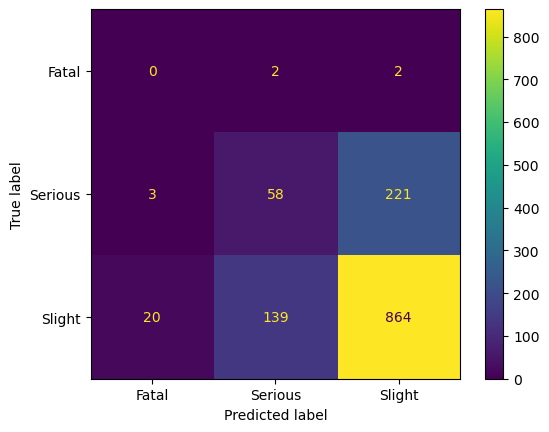

In [110]:
clf = random_search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

#### Trying without imputed values - remove all nulls

In [159]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
df = clean_df(df)
cols = ['day_of_week','time','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
        'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty']
df = df[cols + [target]]
df = df[df != "Missing"]
df.dropna(how='any', inplace=True)
df['time_period'] = (df.time.str.slice(start=0, stop=2).astype('int') // 4)
df['time_period'] = (df['time_period'] * 4).astype('str') + ':00 - ' + ((df['time_period'] + 1) * 4).astype('str') + ':00'

In [160]:
features = ['day_of_week','time_period','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)

In [162]:
counter = Counter(df[target])
print(counter)

Counter({'Slight': 4233, 'Serious': 1288, 'Fatal': 13})


In [173]:
def run_experiment(features, one_hot_encoded_cols=None):
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy={'Slight': 4233, 'Serious': 1288, 'Fatal': 1288})),
        ('under', RandomUnderSampler(sampling_strategy={'Slight': 1288, 'Serious': 1288, 'Fatal': 1288})),
        ('classifier', RandomForestClassifier(n_estimators=500))
    ])
    param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(20, 100, 10)],
        "classifier__max_features": [int(i) for i in np.linspace(50, 160, 10)] + ["sqrt", "log2", None]
        , "classifier__max_depth": [int(i) for i in np.linspace(50, 500, 15)] + [None]
    }
    cv = StratifiedKFold(n_splits=10)
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=30,  # Number of random combinations to try
        scoring='f1_macro',  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42  # Reproducibility
    )
    random_search.fit(df[features], df[target])
    print(random_search.best_score_, random_search.best_params_)

    clf = random_search.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    
    return random_search

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 1/10; 1/30] END classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55;, score=0.339 total time=  10.7s
[CV 2/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 2/10; 1/30] END classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55;, score=0.338 total time=   9.5s
[CV 3/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 3/10; 1/30] END classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55;, score=0.356 total time=  10.1s
[CV 4/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 4/10; 1/30] END classifier__max_depth=371, classifier__m

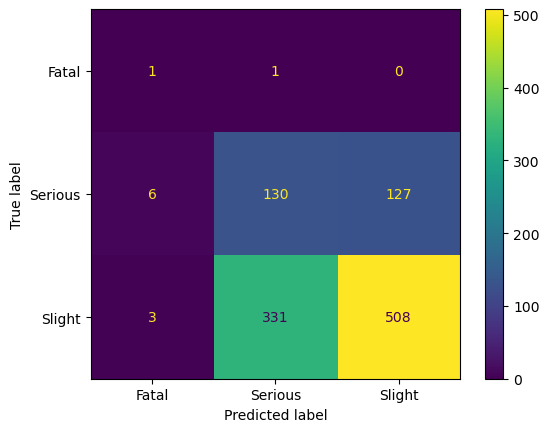

In [174]:
random_search = run_experiment(features)

#### Changing target to binary

In [195]:
df['casualty_grievous_injury'] = np.where(df['casualty_severity'] == "Slight", 0, 1)
target = 'casualty_grievous_injury'

In [196]:
counter = Counter(df[target])
print(counter)

Counter({0: 4233, 1: 1301})


In [200]:
# baseline accuracy -> dummy classifier predicting the most frequent class
for strategy in ["most_frequent", "uniform", "stratified", "prior"]:
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('over', SMOTE()),
        ('classifier', DummyClassifier(strategy=strategy))
    ])
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)
    pipeline.fit(X_train, y_train)
    y_pred_dummy = pipeline.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_dummy)
    f1 = f1_score(y_test, y_pred_dummy)
    print(auc, f1)

0.5 0.0
0.5124802688057897 0.3267326732673267
0.5008145473758365 0.32843137254901966
0.5 0.0


In [206]:
def run_experiment(features, one_hot_encoded_cols=None):
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE()),
        ('classifier', RandomForestClassifier(n_estimators=500))
    ])
    param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(20, 100, 10)],
        "classifier__max_features": [int(i) for i in np.linspace(50, 160, 10)] + ["sqrt", "log2", None]
        , "classifier__max_depth": [int(i) for i in np.linspace(50, 500, 15)] + [None]
    }
    cv = StratifiedKFold(n_splits=10)
    scoring = {
        "f1": make_scorer(f1_score),
        "auc": make_scorer(roc_auc_score)
    }
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=30,  # Number of random combinations to try
        scoring=scoring,  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42,  # Reproducibility
        refit="auc"
    )
    random_search.fit(df[features], df[target])
    print(random_search.best_score_, random_search.best_params_)

    clf = random_search.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    
    return random_search

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 1/10; 1/30] END classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55; auc: (test=0.529) f1: (test=0.221) total time=  19.8s
[CV 2/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 2/10; 1/30] END classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55; auc: (test=0.543) f1: (test=0.255) total time=  20.5s
[CV 3/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55
[CV 3/10; 1/30] END classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_split=55; auc: (test=0.540) f1: (test=0.272) total time=  20.1s
[CV 4/10; 1/30] START classifier__max_depth=371, classifier__max_features=123, classifier__min_samples_spl

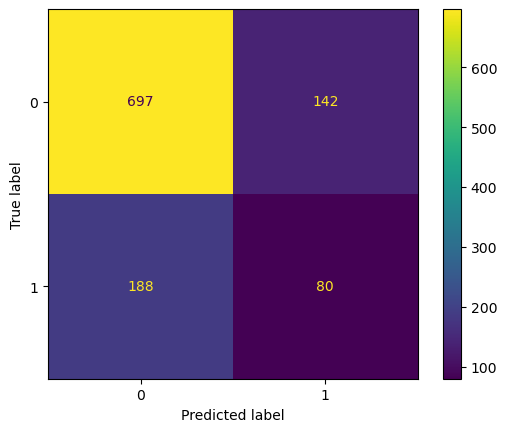

In [207]:
random_search = run_experiment(features)

In [ ]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
df = clean_df(df)
cols = ['day_of_week','time','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
        'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty']
df = df[cols + [target]]
df = df[df != "Missing"]
df.dropna(how='any', inplace=True)
df['time_period'] = (df.time.str.slice(start=0, stop=2).astype('int') // 4)
df['time_period'] = (df['time_period'] * 4).astype('str') + ':00 - ' + ((df['time_period'] + 1) * 4).astype('str') + ':00'

features = ['age_of_casualty','weather_conditions','light_conditions',
            'vehicle_type','junction_detail',
            'pedestrian_crossing_physical_facilities',
            'time_period','first_road_class','road_type',
            'second_road_class','vehicle_subtype']
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2)

one_hot_encoded_cols = [
    'time_period_0:00 - 4:00',
    'first_road_class_A',
    'first_road_class_B',
    'road_type_Slip road',
    'road_type_One way street',
    'road_type_Dual carriageway',
    'road_type_Roundabout',
    'junction_detail_Mini-roundabout',
    'junction_detail_Private drive or entrance',
    'junction_detail_More than 4 arms (not roundabout)',
    'junction_detail_Other junction',
    'junction_detail_Slip road',
    'second_road_class_B',
    'second_road_class_C',
    'light_conditions_Darkness - lighting',
    'light_conditions_Darkness - lights unlit',
    'weather_conditions_Fine + high winds',
    'weather_conditions_Other',
    'weather_conditions_Raining + high winds',
    'vehicle_type_Goods 7.5 tonnes mgw and over',
    'vehicle_type_Goods over 3.5t. and under 7.5t',
    'vehicle_subtype_6. Motorbike',
    'vehicle_subtype_3. Bus',
    'vehicle_subtype_8. Unknown',
    'pedestrian_crossing_physical_facilities_Central refuge',
    'pedestrian_crossing_physical_facilities_Zebra',
    'pedestrian_crossing_physical_facilities_Footbridge or subway',
]

In [ ]:
def run_experiment(features, one_hot_encoded_cols=None):
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE()),
        ('classifier', RandomForestClassifier(n_estimators=500))
    ])
    param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(20, 100, 10)],
        "classifier__max_features": [int(i) for i in np.linspace(50, 160, 10)] + ["sqrt", "log2", None]
        , "classifier__max_depth": [int(i) for i in np.linspace(50, 500, 15)] + [None]
    }
    cv = StratifiedKFold(n_splits=10)
    scoring = {
        "f1": make_scorer(f1_score),
        "auc": make_scorer(roc_auc_score)
    }
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=30,  # Number of random combinations to try
        scoring=scoring,  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42,  # Reproducibility
        refit="auc"
    )
    random_search.fit(df[features], df[target])
    print(random_search.best_score_, random_search.best_params_)

    clf = random_search.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    
    return random_search

In [ ]:
random_search = run_experiment(features, one_hot_encoded_cols)